## Imports


In [1]:
# !pip install Tensorflow
# !pip install Keras
# !pip install scikit-learn
# !pip install imblearn
# !pip install scikeras
# !pip install gensim
# !pip install keras-tuner


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import set_random_seed

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import os
import zipfile
import keras_tuner as kt

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
set_random_seed(8)

## Loading the data

In [4]:
df = pd.read_csv('data/original_v2_data.csv', index_col =0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1


In [5]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [8]:
df.shape

(28619, 2)

## Splitting data

In [9]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [10]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125, random_state = 8)

In [11]:
X_train.sample(5)

4049                  being moody helps us adapt to change
5126                              bandai recalls lady gaga
870      john legend tries in earnest to talk kanye wes...
18122    want to sleep in 'the world's largest grave'? ...
19098    ayesha curry lands cooking show on the food ne...
Name: headline, dtype: object

In [12]:
y_train.sample(5)

20986    1
24440    1
8150     1
8251     1
15112    1
Name: is_sarcastic, dtype: int64

## Model statistics

In [13]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

In [14]:


def printModelStats(model, X, y):

    y_pred = model.predict(X)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1    


    print(classification_report(y, y_pred, target_names = ['Sarcastic', 'Not Sarcastic']))
   
    cm = confusion_matrix(y, y_pred)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

## Tokenizing

In [15]:
tokenizer = Tokenizer(oov_token="<OOV>")

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#choosing max length to be 20, which is is more than 2*STD +- mean number of words per headline
max_length = 20 # max([len(sentence.split()) for sentence in X_train])

X_train_untk = X_train

In [16]:
#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [17]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 25928


## Simple bidirectional LSTM

### Model definition

In [18]:
output_dimension = 100

def buildLSTM1(hp):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length))
    model_lstm.add(LSTM(hp.Choice('units1', [16, 32, 64])))
    model_lstm.add(Dropout(hp.Choice('rate1', [0.3, 0.5, 0.7])))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.summary()
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm


In [19]:

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


### Model tuning + training

In [24]:
# history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


tuner = kt.RandomSearch(buildLSTM1, objective= 'val_loss', seed = 8, max_trials=10, directory= 'models', project_name = 'model_LSTM_original_1')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Trial 9 Complete [00h 00m 44s]
val_loss: 0.3173067569732666

Best val_loss So Far: 0.3173067569732666
Total elapsed time: 00h 06m 19s


In [25]:
best_model = tuner.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2592800   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2609857 (9.96 MB)
Trainable params: 2609857 (9.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Best model + results

In [26]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model_1 = tuner.hypermodel.build(best_hp)
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2609857 (9.96 MB)
Trainable params: 2609857 (9.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
units1: 32
rate1: 0.7


In [27]:
history = best_model_1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


Epoch 1/20
627/627 [==============================] - 18s 26ms/step - loss: 0.4397 - accuracy: 0.7844 - val_loss: 0.3181 - val_accuracy: 0.8581
Epoch 2/20
627/627 [==============================] - 13s 21ms/step - loss: 0.1923 - accuracy: 0.9310 - val_loss: 0.3896 - val_accuracy: 0.8592
Epoch 3/20
627/627 [==============================] - 14s 22ms/step - loss: 0.0919 - accuracy: 0.9691 - val_loss: 0.4252 - val_accuracy: 0.8505
Epoch 3: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_14432/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


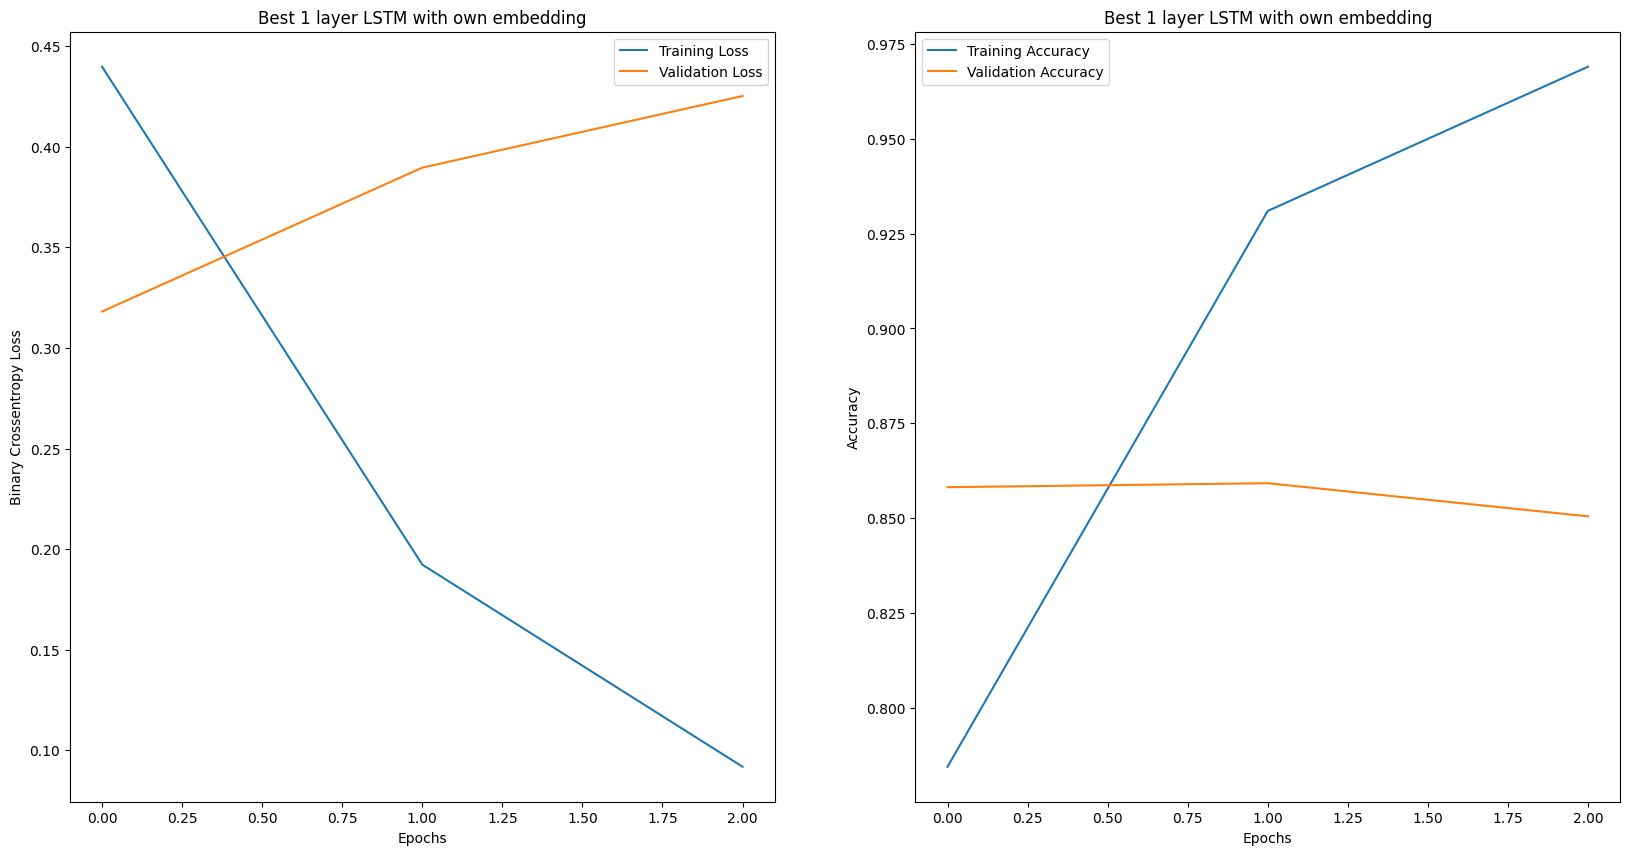

In [28]:
plotCurves(history, "Best 1 layer LSTM with own embedding")

printModelStats(model)

90/90 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

    Sarcastic       0.89      0.83      0.86      1472
Not Sarcastic       0.83      0.89      0.86      1390

     accuracy                           0.86      2862
    macro avg       0.86      0.86      0.86      2862
 weighted avg       0.86      0.86      0.86      2862

The confusion matrix:
[[1224  248]
 [ 158 1232]]


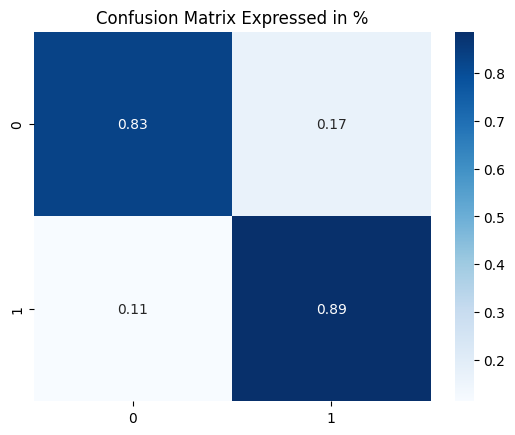

In [29]:
printModelStats(best_model_1, X_val, y_val)

## LSTM with Word2Vec Embedding

In [30]:
output_dimension = 100


#Training Word2Vec embedding layer using Skip grams
sentences = [sentence.split() for sentence in X_train_untk]
w2v = Word2Vec(sentences, vector_size = output_dimension, sg=1)

#Creating the embedding weight matrix
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]



In [31]:
output_dimension = 100

def LSTM_w2vec(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add(LSTM(hp.Choice('units1', [16,32,64])))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [32]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [33]:
tuner = kt.RandomSearch(LSTM_w2vec, objective= 'val_loss', seed = 8, max_trials=10, directory= 'models', project_name = 'LSTM_w2vec')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Trial 9 Complete [00h 00m 48s]
val_loss: 0.3159494996070862

Best val_loss So Far: 0.3068344295024872
Total elapsed time: 00h 07m 03s


In [35]:
best_hp_lstm_w2vec = tuner.get_best_hyperparameters()[0]
best_model_lstm_w2vec = tuner.hypermodel.build(best_hp_lstm_w2vec)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2609857 (9.96 MB)
Trainable params: 2609857 (9.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history_lstm_w2vec = best_model_lstm_w2vec.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)



Epoch 1/20
627/627 [==============================] - 15s 23ms/step - loss: 0.1737 - accuracy: 0.9350 - val_loss: 0.4151 - val_accuracy: 0.8312
Epoch 2/20
627/627 [==============================] - 13s 21ms/step - loss: 0.0748 - accuracy: 0.9758 - val_loss: 0.4834 - val_accuracy: 0.8407
Epoch 3/20
627/627 [==============================] - 13s 20ms/step - loss: 0.0338 - accuracy: 0.9898 - val_loss: 0.6340 - val_accuracy: 0.8309
Epoch 3: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_14432/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


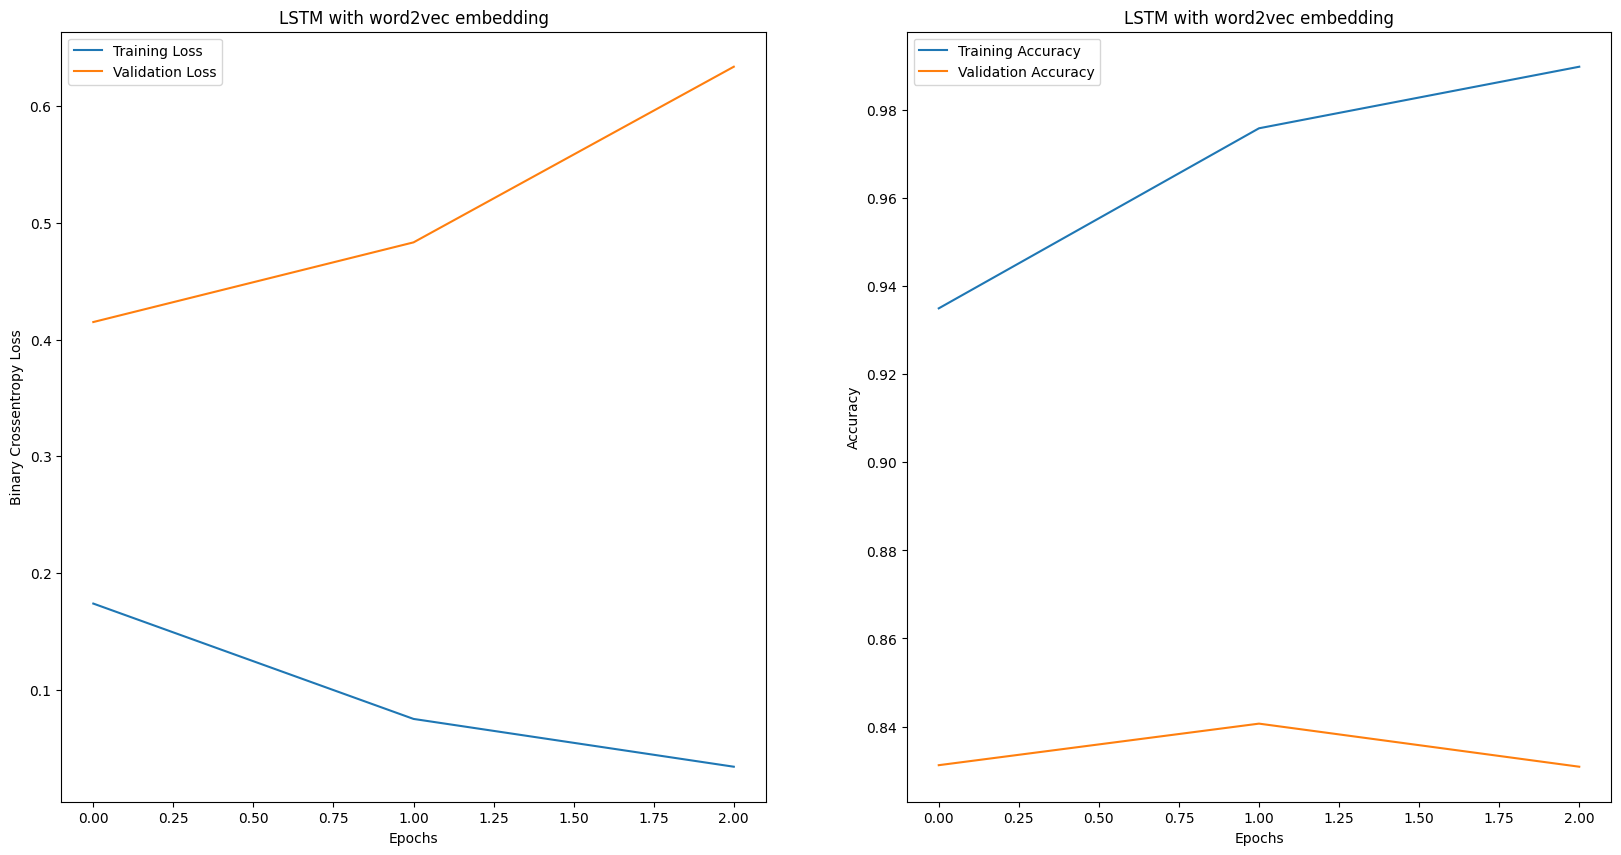

In [45]:
plotCurves(history_lstm_w2vec, "LSTM with word2vec embedding")

90/90 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

    Sarcastic       0.90      0.76      0.82      1472
Not Sarcastic       0.78      0.91      0.84      1390

     accuracy                           0.83      2862
    macro avg       0.84      0.83      0.83      2862
 weighted avg       0.84      0.83      0.83      2862

The confusion matrix:
[[1114  358]
 [ 125 1265]]


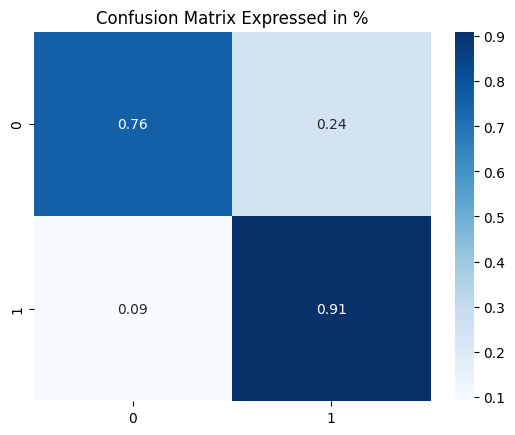

In [39]:
printModelStats(best_model_lstm_w2vec, X_val, y_val)


## With glove embedding

In [40]:

from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
     
    #trying to find word in glove model
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]



In [41]:
output_dimension = 100
def buildModel3(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [42]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [43]:
tuner = kt.RandomSearch(buildModel3, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_3')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Reloading Tuner from C:/projects/model_GRU_original_3/tuner0.json


In [44]:
best_hp3 = tuner.get_best_hyperparameters()[0]
best_model_3 = tuner.hypermodel.build(best_hp3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2685281 (10.24 MB)
Trainable params: 268

In [ ]:
history = best_model_3.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20
314/314 [==============================] - 19s 55ms/step - loss: 0.5358 - accuracy: 0.7120 - val_loss: 0.3962 - val_accuracy: 0.8222
Epoch 2/20
314/314 [==============================] - 10s 30ms/step - loss: 0.2851 - accuracy: 0.8820 - val_loss: 0.3203 - val_accuracy: 0.8690
Epoch 3/20
314/314 [==============================] - 9s 28ms/step - loss: 0.1636 - accuracy: 0.9375 - val_loss: 0.3039 - val_accuracy: 0.8725
Epoch 4/20
314/314 [==============================] - 8s 26ms/step - loss: 0.1069 - accuracy: 0.9621 - val_loss: 0.3894 - val_accuracy: 0.8651
Epoch 5/20
314/314 [==============================] - 8s 27ms/step - loss: 0.0594 - accuracy: 0.9797 - val_loss: 0.5587 - val_accuracy: 0.8578
Epoch 5: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_80456/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


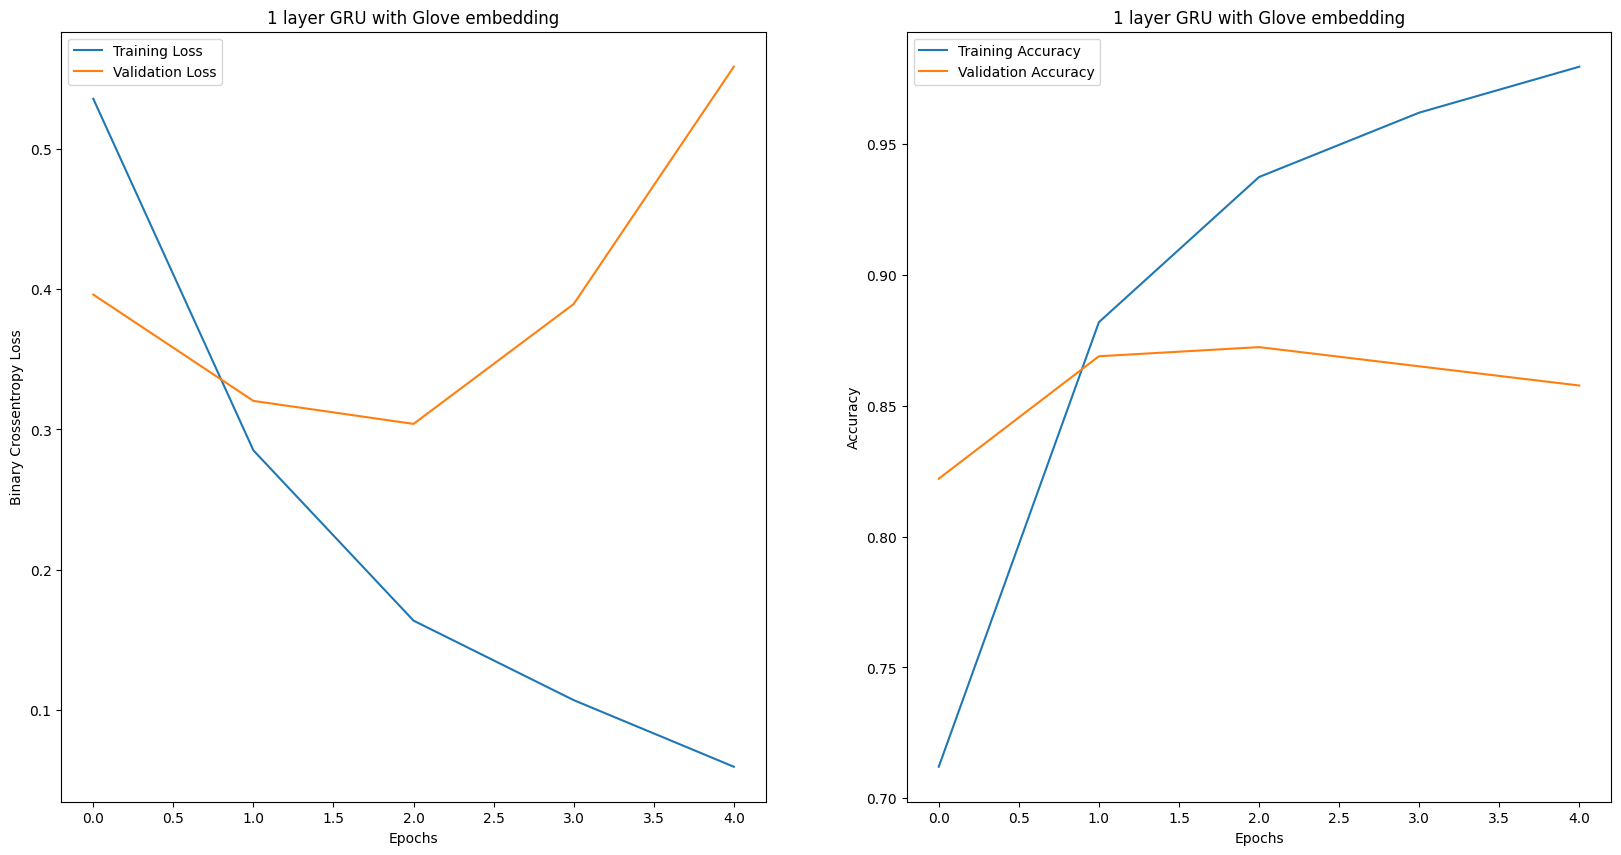

In [ ]:
plotCurves(history, "1 layer GRU with Glove embedding")

90/90 [==============================] - 1s 6ms/step
               precision    recall  f1-score   support

    Sarcastic       0.86      0.90      0.88      1472
Not Sarcastic       0.89      0.84      0.87      1390

     accuracy                           0.87      2862
    macro avg       0.87      0.87      0.87      2862
 weighted avg       0.87      0.87      0.87      2862

The confusion matrix:
[[1324  148]
 [ 217 1173]]


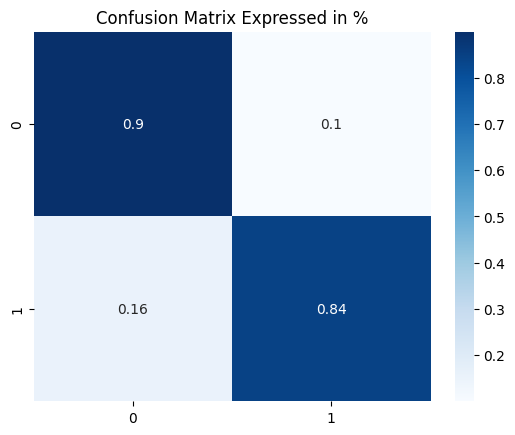

In [ ]:
printModelStats(best_model_3, X_val, y_val)